# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), August 30, 2019**

In [1]:
using Pkg
Pkg.activate(".")

Activating environment at `D:\Dev\Julia\DataFrames_Tutorial\Project.toml`


In [2]:
using DataFrames

## Load and save DataFrames
We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load `CSV` and `CSVFiles` to read and write CSV files and `Feather`, `JLSO`, and serialization, which allow us to work with a binary format and `JSONTables` for JSON interaction.

In [3]:
using CSV
using CSVFiles
using Serialization
using JLSO
using Feather
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts

Let's create a simple `DataFrame` for testing purposes,

In [4]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])


,A,B,C,D
,Bool,Int64⍰,String⍰,Char⍰
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = compacttype(::Type, ::Int64) at show.jl:39
└ @ DataFrames D:\AppData\.julia\packages\DataFrames\XuYBH\src\abstractdataframe\show.jl:39


and use `eltypes` to look at the columnwise types.

In [5]:
eltypes(x)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, Char}  

### CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [6]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [7]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back (`use_mmap=false` disables memory mapping so that on Windows the file can be deleted in the same session, on other OSs it is not needed).

In [8]:
y = CSV.read("x1.csv", use_mmap=false)

,A,B,C,D
,Bool,Int64⍰,String⍰,String⍰
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


When loading in a `DataFrame` from a `CSV`, all columns allow `Missing` by default. Note that the column types have changed!

In [9]:
eltypes(y)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, String}

### CSVFiles.jl

Now we will use `CSVFiles` to achieve the same. First we save the file. Notice that we override default `nastring` that is `"NA"` because we have missings in non-numeric columns.

In [10]:
x |> save("x2.csv", nastring="")

and peek the saved file:

In [11]:
print(read("x2.csv", String))

"A","B","C","D"
true,1,,a
false,2,"b",
true,,"c",c


We can load it back using `load`:

In [12]:
y = load("x2.csv") |> DataFrame

,A,B,C,D
,String,Int64⍰,String,String
1,true,1,,a
2,false,2,b,
3,true,missing,c,c


Let us check element types again:

In [13]:
eltypes(y)

4-element Array{Type,1}:
 String               
 Union{Missing, Int64}
 String               
 String               

Observe that in columns `:C` and `:D` missings were read back as empty strings

### Serialization, JDF.jl, and JLSO.jl

#### Serialization

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [14]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [15]:
y = open(deserialize, "x.bin")

,A,B,C,D
,Bool,Int64⍰,String⍰,Char⍰
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


In [16]:
eltypes(y)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, Char}  

#### JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

In [17]:
savejdf("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [18]:
x_loaded = loadjdf("x.jdf")

,A,B,C,D
,Bool,Int64⍰,String⍰,Char⍰
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


You can see that they are the same

In [19]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [20]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [21]:
names(x_ondisk)

4-element Array{Symbol,1}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D` 

In [22]:
xd = sloadjdf(x_ondisk; cols = [:A, :D])

,A,D
,Bool,Char⍰
1,1,'a'
2,0,missing
3,1,'c'


##### JDF.jl vs others

JDF.jl is specialized to DataFrames and only supports a restricted list of columns, so it can not save DataFrames with arbitrary column types. However, this also means that JDF.jl has specialised algorithms to serailize the type it supports to optimize speed, minimize disk usage, and reduce the chance of errors

The list support columns for JDF include

```julia
WeakRefStrings.StringVector
Vector{T}, Vector{Union{Mising, T}}, Vector{Union{Nothing, T}}
CategoricalArrays.CategoricalVetors{T}
```

where `T` can be `String`, `Bool`, `Symbol`, `Char`, `TimeZones.ZonedDateTime` (experimental) and `isbit`s types i.e. `UInt*`, `Int*`, `Float*`, and `Date*` types etc.

#### JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [23]:
JLSO.save("x.jlso", x)

Now we can laod back the file to `y`

In [24]:
y = JLSO.load("x.jlso")["data"]

,A,B,C,D
,Bool,Int64⍰,String⍰,Char⍰
1,1,1,missing,'a'
2,0,2,b,missing
3,1,missing,c,'c'


In [25]:
eltypes(y)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, Char}  

### JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [26]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [27]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [28]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [29]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [30]:
y1 = open(jsontable, "x1.json") |> DataFrame

,A,B,C,D
,Bool,Int64⍰,String⍰,String⍰
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [31]:
eltypes(y1)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, String}

In [32]:
y2 = open(jsontable, "x2.json") |> DataFrame

,A,B,C,D
,Bool,Int64⍰,String⍰,String⍰
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [33]:
eltypes(y2)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, String}

### Feather.jl

Finally we use Feather format that allows, in particular, for data interchange with R or Python.

In [34]:
x.D = passmissing(string).(x.D) # Feather format does not support Char type

3-element Array{Union{Missing, String},1}:
 "a"    
 missing
 "c"    

In [35]:
Feather.write("x.feather", x)

"x.feather"

In [36]:
y = Feather.materialize("x.feather") # Feather.read is a lazy alternative

,A,B,C,D
,Bool,Int64⍰,String⍰,String⍰
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [37]:
eltypes(y)

4-element Array{Type,1}:
 Bool                  
 Union{Missing, Int64} 
 Union{Missing, String}
 Union{Missing, String}

### Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 10^3 rows and 10^5 columns.

In [38]:
bigdf = DataFrame(rand(Bool, 10^5, 500))
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("CSVFiles.jl")
csvfileswrite1 = @elapsed @time bigdf |> save("bigdf2.csv")
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", bigdf)
println("Feather.jl")
featherwrite1 = @elapsed @time Feather.write("bigdf.feather", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("CSVFiles.jl")
csvfileswrite2 = @elapsed @time bigdf |> save("bigdf2.csv")
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time savejdf("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", bigdf)
println("Feather.jl")
featherwrite2 = @elapsed @time Feather.write("bigdf.feather", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
  6.940504 seconds (52.09 M allocations: 887.504 MiB, 2.58% gc time)
CSVFiles.jl
  6.933183 seconds (3.36 M allocations: 213.178 MiB, 1.05% gc time)
Serialization
  0.491245 seconds (419.88 k allocations: 21.589 MiB, 1.11% gc time)
JDF.jl
  0.523319 seconds (101.43 k allocations: 169.044 MiB, 4.39% gc time)
JLSO.jl
  7.573698 seconds (389.51 k allocations: 183.972 MiB, 0.59% gc time)
Feather.jl
  0.323371 seconds (501.27 k allocations: 50.084 MiB, 34.69% gc time)
JSONTables.jl arraytable
 83.369164 seconds (1.05 G allocations: 27.823 GiB, 7.19% gc time)
JSONTables.jl objecttable
  1.725698 seconds (433.86 k allocations: 1.402 GiB, 19.17% gc time)
Second run
CSV.jl
  5.372882 seconds (50.25 M allocations: 788.983 MiB, 1.88% gc time)
CSVFiles.jl
  3.035051 seconds (406.63 k allocations: 64.416 MiB, 0.17% gc time)
Serialization
  0.402675 seconds (5.39 k allocations: 760.513 KiB)
JDF.jl
  0.527185 seconds (22.51 k allocations: 165.052 MiB, 3.66% gc time)
JLSO.jl
  8.11356

1.612961399

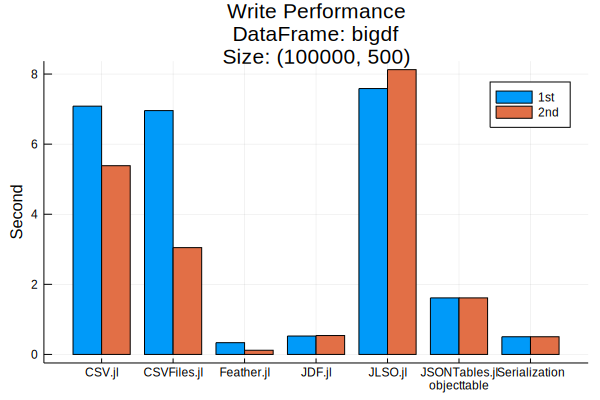

In [39]:
groupedbar(
    #repeat(["CSV.jl", "CSVFiles.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\narraytable", "JSONTables.jl\nobjecttable"], inner = 2),
    #[csvwrite1, csvwrite2, csvfileswrite1, csvfileswrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2, jlsowrite1, jlsowrite2, featherwrite1, featherwrite2, jsontablesawrite1, jsontablesawrite2, jsontablesowrite2, jsontablesowrite2],
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "CSVFiles.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\nobjecttable"], inner = 2),
    [csvwrite1, csvwrite2, csvfileswrite1, csvfileswrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2, jlsowrite1, jlsowrite2, featherwrite1, featherwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [40]:
data_files = ["bigdf1.csv", "bigdf2.csv", "bigdf.bin", "bigdf.feather", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files,
          size = getfield.(stat.(data_files), :size))


append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size, stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))), init=0)))

,file,size
,String,Int64
1,bigdf1.csv,275804589
2,bigdf2.csv,275805589
3,bigdf.bin,28208794
4,bigdf.feather,9798144
5,bigdf1.json,615202198
6,bigdf2.json,275806590
7,bigdf.jdf,26017099


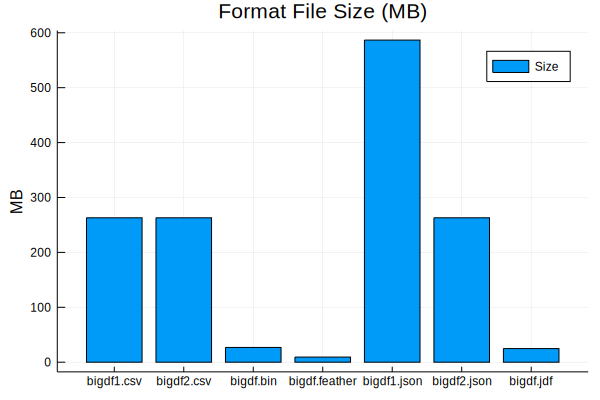

In [41]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [42]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv")
println("CSVFiles.jl")
println("  disabled due to time-out")
# @time load("bigdf2.csv") |> DataFrame
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Feather.jl")
featherread1 = @elapsed @time Feather.materialize("bigdf.feather")
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv")
println("CSVFiles.jl")
println("  disabled due to time-out")
# @time load("bigdf2.csv") |> DataFrame
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time loadjdf("bigdf.jdf")
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Feather.jl")
featherread2 = @elapsed @time Feather.materialize("bigdf.feather")
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  1.802067 seconds (66.70 k allocations: 3.724 MiB, 0.68% gc time)
CSVFiles.jl
  disabled due to time-out
Serialization
  1.552420 seconds (49.69 M allocations: 812.160 MiB, 12.83% gc time)
JDF.jl
  0.656944 seconds (194.73 k allocations: 156.398 MiB, 3.48% gc time)
JLSO.jl
  1.714849 seconds (49.68 M allocations: 819.835 MiB, 10.71% gc time)
Feather.jl
  0.633100 seconds (762.13 k allocations: 144.927 MiB, 27.01% gc time)
JSONTables.jl arraytable
  2.941522 seconds (31 allocations: 586.704 MiB, 5.07% gc time)
JSONTables.jl objecttable
  1.995607 seconds (26 allocations: 263.031 MiB, 9.35% gc time)
Second run
  2.158438 seconds (5.13 k allocations: 292.148 KiB)
CSVFiles.jl
  disabled due to time-out
Serialization
  2.062672 seconds (49.65 M allocations: 810.176 MiB, 10.66% gc time)
JDF.jl
  0.679759 seconds (27.59 k allocations: 148.272 MiB, 2.84% gc time)
JLSO.jl
  2.540171 seconds (49.66 M allocations: 819.178 MiB, 10.10% gc time)
Feather.jl
  0.484136 seconds (230.3

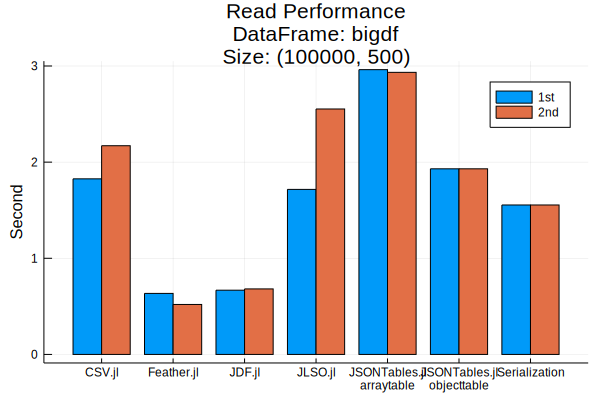

In [43]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Feather.jl", "JSONTables.jl\narraytable", "JSONTables.jl\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread1, jdfread1, jdfread2, jlsoread1, jlsoread2, featherread1, featherread2, jsontablesaread1, jsontablesaread2, jsontablesoread2, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

### Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip.
Below we show how this can be accomplished using CodecZlib.jl.
The same pattern is applicable to JSONTables.jl compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory

We first generate a random data frame

In [44]:
df = DataFrame(rand(1:10, 10, 1000))

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3,3,6,3,1,2,1,1,7,4,7,7,8,2,10,3,2,9,4,10,5,2,7,2,1,2,2,4,5,7,1,10,3,6,9,5,4,1,8,6,6,4,6,2,10,6,9,10,3,7,1,5,5,5,1,7,5,9,5,6,2,6,1,7,7,6,8,10,3,5,10,10,1,3,3,1,7,8,10,3,7,7,2,4,2,9,5,6,4,1,1,7,6,8,9,1,5,1,8,9,4,9,8,5,8,3,8,1,9,6,1,10,10,8,4,4,6,1,7,4,8,2,2,9,3,8,4,6,5,4,2,9,4,5,5,8,1,9,8,9,10,6,9
2,2,10,6,4,10,9,7,4,6,5,6,5,2,4,4,8,10,6,7,5,9,10,3,8,10,8,5,6,8,3,8,2,7,7,7,8,7,9,3,6,3,3,8,10,7,8,6,4,4,8,5,10,1,5,1,10,8,1,3,9,6,8,2,9,2,10,10,3,4,8,10,5,6,7,5,6,9,7,10,4,10,2,10,1,5,8,4,9,6,5,5,3,4,1,10,4,7,8,2,10,1,4,4,1,6,8,2,8,6,5,5,4,4,1,5,6,6,6,7,7,2,7,6,3,7,4,10,7,1,2,8,5,8,4,1,6,8,7,4,10,1,8,3
3,6,4,10,6,2,6,6,9,4,1,5,6,7,9,8,6,7,1,6,7,4,10,3,4,1,7,10,4,4,4,5,5,7,2,10,4,7,10,6,10,2,2,10,6,8,3,6,2,9,10,7,7,1,7,3,7,10,10,9,2,7,7,1,3,4,9,3,5,7,10,7,3,3,5,9,10,9,3,1,7,3,7,1,1,4,2,9,3,10,1,5,8,7,7,1,3,6,4,9,4,3,1,1,1,10,10,4,8,6,8,2,3,9,8,9,1,3,2,4,9,1,8,2,3,1,1,8,2,6,7,1,7,2,9,10,5,10,4,4,2,9,4,5
4,10,4,5,10,7,8,6,6,10,6,3,1,8,1,5,10,8,2,8,4,5,1,10,10,3,5,1,4,9,4,1,5,1,3,1,9,7,6,7,1,3,8,4,5,1,2,7,9,10,1,1,5,7,10,10,10,1,9,10,7,2,5,5,1,3,9,6,5,9,4,1,5,3,2,9,4,1,3,2,9,3,9,7,8,1,3,1,4,8,9,9,9,4,6,7,6,9,10,10,6,6,10,5,4,8,6,10,9,7,5,2,2,8,2,8,7,8,2,2,7,1,5,7,9,2,6,3,5,2,2,7,9,1,8,3,10,10,10,2,5,6,2,1
5,1,6,8,5,10,3,6,10,7,3,4,2,3,2,3,2,8,4,5,6,2,1,4,9,5,7,10,4,4,10,5,4,3,5,5,2,6,3,1,9,9,5,3,2,6,3,4,8,9,5,7,1,8,9,3,10,9,5,5,9,9,3,3,7,1,6,7,10,3,10,9,10,4,3,2,10,7,2,3,10,2,6,5,6,4,4,5,10,9,8,10,8,5,2,5,4,6,7,3,5,1,10,7,7,7,9,3,2,8,7,5,1,5,9,9,10,10,2,6,2,8,2,7,4,1,6,6,5,4,1,10,8,7,10,9,10,6,8,1,10,1,5,10
6,8,6,7,9,6,9,10,8,4,2,10,7,1,1,9,4,3,2,3,2,10,2,3,3,8,3,4,10,6,6,4,8,4,9,2,8,10,6,3,8,7,7,2,5,4,5,10,1,6,7,6,1,5,1,4,4,2,5,10,5,5,5,7,3,4,8,8,9,3,2,7,1,2,1,8,5,8,8,7,3,1,5,9,8,8,1,5,8,5,3,2,10,6,8,2,10,3,9,1,10,6,4,8,2,3,5,1,3,6,5,3,3,9,10,10,1,8,7,10,3,6,1,2,1,8,1,4,1,2,8,1,10,2,8,3,2,4,4,1,1,6,7,6
7,6,9,2,10,10,1,8,6,7,9,3,3,10,8,4,9,7,10,2,2,5,2,8,9,3,9,2,9,2,6,10,3,5,5,6,8,3,1,5,3,1,5,3,3,4,2,7,5,10,9,3,1,8,7,10,8,10,8,2,10,4,7,1,2,9,5,3,5,8,2,8,1,8,5,7,4,5,3,8,1,7,7,9,10,2,8,4,2,1,7,2,3,6,4,3,10,5,3,10,7,3,5,5,7,6,3,1,1,5,8,3,7,7,6,10,10,3,2,10,5,4,8,4,4,10,6,10,5,4,10,4,4,4,2,4,6,5,7,8,5,5,5,9
8,9,1,5,10,5,5,10,9,9,10,6,7,8,4,3,2,6,5,5,6,2,10,4,9,10,1,9,6,9,9,4,5,4,2,5,2,9,4,2,5,6,2,9,6,3,9,8,8,2,9,8,6,10,7,4,7,2,10,10,7,6,8,8,4,4,6,3,2,6,10,7,6,9,9,5,4,7,5,2,6,8,3,4,5,5,1,1,6,3,5,6,7,1,8,5,6,9,5,10,4,5,4,6,5,3,8,1,5,5,7,3,9,8,10,3,1,5,10,7,9,5,6,6,6,2,10,8,4,1,6,9,4,4,6,10,9,8,2,4,5,3,8,1
9,1,10,7,3,8,8,5,9,8,5,2,7,1,1,9,3,8,5,10,9,5,8,5,10,2,4,2,6,7,9,1,6,6,8,7,6,10,1,10,6,6,10,9,4,8,

In [45]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = open("df_compress_test.csv.gz") do io
    stream = GzipDecompressorStream(io)
    res = CSV.read(stream)
    close(stream)
    res
end

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3,3,6,3,1,2,1,1,7,4,7,7,8,2,10,3,2,9,4,10,5,2,7,2,1,2,2,4,5,7,1,10,3,6,9,5,4,1,8,6,6,4,6,2,10,6,9,10,3,7,1,5,5,5,1,7,5,9,5,6,2,6,1,7,7,6,8,10,3,5,10,10,1,3,3,1,7,8,10,3,7,7,2,4,2,9,5,6,4,1,1,7,6,8,9,1,5,1,8,9,4,9,8,5,8,3,8,1,9,6,1,10,10,8,4,4,6,1,7,4,8,2,2,9,3,8,4,6,5,4,2,9,4,5,5,8,1,9,8,9,10,6,9
2,2,10,6,4,10,9,7,4,6,5,6,5,2,4,4,8,10,6,7,5,9,10,3,8,10,8,5,6,8,3,8,2,7,7,7,8,7,9,3,6,3,3,8,10,7,8,6,4,4,8,5,10,1,5,1,10,8,1,3,9,6,8,2,9,2,10,10,3,4,8,10,5,6,7,5,6,9,7,10,4,10,2,10,1,5,8,4,9,6,5,5,3,4,1,10,4,7,8,2,10,1,4,4,1,6,8,2,8,6,5,5,4,4,1,5,6,6,6,7,7,2,7,6,3,7,4,10,7,1,2,8,5,8,4,1,6,8,7,4,10,1,8,3
3,6,4,10,6,2,6,6,9,4,1,5,6,7,9,8,6,7,1,6,7,4,10,3,4,1,7,10,4,4,4,5,5,7,2,10,4,7,10,6,10,2,2,10,6,8,3,6,2,9,10,7,7,1,7,3,7,10,10,9,2,7,7,1,3,4,9,3,5,7,10,7,3,3,5,9,10,9,3,1,7,3,7,1,1,4,2,9,3,10,1,5,8,7,7,1,3,6,4,9,4,3,1,1,1,10,10,4,8,6,8,2,3,9,8,9,1,3,2,4,9,1,8,2,3,1,1,8,2,6,7,1,7,2,9,10,5,10,4,4,2,9,4,5
4,10,4,5,10,7,8,6,6,10,6,3,1,8,1,5,10,8,2,8,4,5,1,10,10,3,5,1,4,9,4,1,5,1,3,1,9,7,6,7,1,3,8,4,5,1,2,7,9,10,1,1,5,7,10,10,10,1,9,10,7,2,5,5,1,3,9,6,5,9,4,1,5,3,2,9,4,1,3,2,9,3,9,7,8,1,3,1,4,8,9,9,9,4,6,7,6,9,10,10,6,6,10,5,4,8,6,10,9,7,5,2,2,8,2,8,7,8,2,2,7,1,5,7,9,2,6,3,5,2,2,7,9,1,8,3,10,10,10,2,5,6,2,1
5,1,6,8,5,10,3,6,10,7,3,4,2,3,2,3,2,8,4,5,6,2,1,4,9,5,7,10,4,4,10,5,4,3,5,5,2,6,3,1,9,9,5,3,2,6,3,4,8,9,5,7,1,8,9,3,10,9,5,5,9,9,3,3,7,1,6,7,10,3,10,9,10,4,3,2,10,7,2,3,10,2,6,5,6,4,4,5,10,9,8,10,8,5,2,5,4,6,7,3,5,1,10,7,7,7,9,3,2,8,7,5,1,5,9,9,10,10,2,6,2,8,2,7,4,1,6,6,5,4,1,10,8,7,10,9,10,6,8,1,10,1,5,10
6,8,6,7,9,6,9,10,8,4,2,10,7,1,1,9,4,3,2,3,2,10,2,3,3,8,3,4,10,6,6,4,8,4,9,2,8,10,6,3,8,7,7,2,5,4,5,10,1,6,7,6,1,5,1,4,4,2,5,10,5,5,5,7,3,4,8,8,9,3,2,7,1,2,1,8,5,8,8,7,3,1,5,9,8,8,1,5,8,5,3,2,10,6,8,2,10,3,9,1,10,6,4,8,2,3,5,1,3,6,5,3,3,9,10,10,1,8,7,10,3,6,1,2,1,8,1,4,1,2,8,1,10,2,8,3,2,4,4,1,1,6,7,6
7,6,9,2,10,10,1,8,6,7,9,3,3,10,8,4,9,7,10,2,2,5,2,8,9,3,9,2,9,2,6,10,3,5,5,6,8,3,1,5,3,1,5,3,3,4,2,7,5,10,9,3,1,8,7,10,8,10,8,2,10,4,7,1,2,9,5,3,5,8,2,8,1,8,5,7,4,5,3,8,1,7,7,9,10,2,8,4,2,1,7,2,3,6,4,3,10,5,3,10,7,3,5,5,7,6,3,1,1,5,8,3,7,7,6,10,10,3,2,10,5,4,8,4,4,10,6,10,5,4,10,4,4,4,2,4,6,5,7,8,5,5,5,9
8,9,1,5,10,5,5,10,9,9,10,6,7,8,4,3,2,6,5,5,6,2,10,4,9,10,1,9,6,9,9,4,5,4,2,5,2,9,4,2,5,6,2,9,6,3,9,8,8,2,9,8,6,10,7,4,7,2,10,10,7,6,8,8,4,4,6,3,2,6,10,7,6,9,9,5,4,7,5,2,6,8,3,4,5,5,1,1,6,3,5,6,7,1,8,5,6,9,5,10,4,5,4,6,5,3,8,1,5,5,7,3,9,8,10,3,1,5,10,7,9,5,6,6,6,2,10,8,4,1,6,9,4,4,6,10,9,8,2,4,5,3,8,1
9,1,10,7,3,8,8,5,9,8,5,2,7,1,1,9,3,8,5,10,9,5,8,5,10,2,4,2,6,7,9,1,6,6,8,7,6,10,1,10,6,6,10,9,4,8,

In [47]:
df == df2

true

### Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4))

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,5,7,7,1
2,5,8,1,1
3,10,1,5,6


In [49]:
df2 = DataFrame(rand(1:10, 3, 4))

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,2,7,4,6
2,1,1,6,2
3,8,7,7,3


And we show yet another way to write a `DataFrame` into a CSV file

In [50]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [51]:
z = ZipFile.Reader("x.zip");

In [52]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(z.files[index_xcsv])

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,5,7,7,1
2,5,8,1,1
3,10,1,5,6


In [53]:
df1_2 == df1

true

In [54]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(z.files[index_xcsv])

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,2,7,4,6
2,1,1,6,2
3,8,7,7,3


In [55]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [56]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [57]:
foreach(rm, ["x1.csv", "x2.csv", "x.bin", "x.jlso", "x.feather", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf2.csv", "bigdf.bin", "bigdf.jlso", "bigdf.feather", "bigdf1.json", "bigdf2.json", 
             "df_compress_test.csv.gz", "x.zip"])

rm("bigdf.jdf", force = true, recursive=true)
rm("x.jdf", force = true, recursive=true)